## Importing the relevant libraries

In [1]:
import torch, time
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


## Loading the dataset

In [3]:
df = pd.read_csv("/kaggle/input/obesity-or-cvd-risk/ObesityDataSet.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Data Exploration

In [4]:
df.shape

(2111, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [6]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [8]:
df.duplicated().sum()

24

In [9]:
df = df.drop_duplicates()
df.shape

(2087, 17)

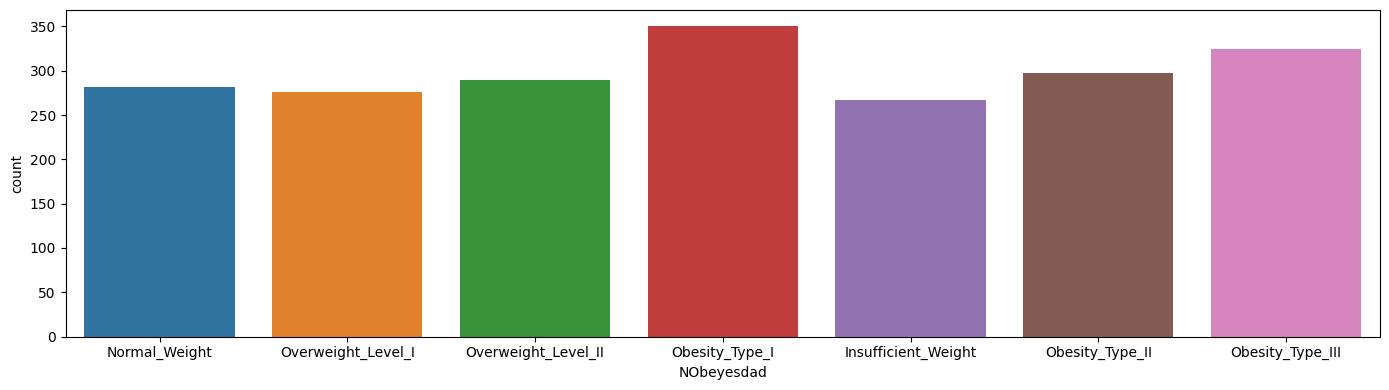

In [10]:
plt.figure(figsize=(14,4))
sns.countplot(data=df,x='NObeyesdad')
plt.tight_layout()
plt.show();

## Encoding the target label classes

In [11]:
encoder = LabelEncoder()
df.NObeyesdad = encoder.fit_transform(df[['NObeyesdad']])
df.NObeyesdad = df.NObeyesdad.astype(float)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
encoded_labels = {}

for idx, label in enumerate(encoder.classes_):
    encoded_labels[idx] = label

encoded_labels

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Obesity_Type_I',
 3: 'Obesity_Type_II',
 4: 'Obesity_Type_III',
 5: 'Overweight_Level_I',
 6: 'Overweight_Level_II'}

## Converting categorical and numerical features into tensors

In [13]:
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS']
cont_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
y_col = 'NObeyesdad'

for col in cat_cols:
    df[col] = df[col].astype('category')

In [14]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats[:5]

array([[0, 1, 0, 2, 0, 0, 3, 3],
       [0, 1, 0, 2, 1, 1, 2, 3],
       [1, 1, 0, 2, 0, 0, 1, 3],
       [1, 0, 0, 2, 0, 0, 1, 4],
       [1, 0, 0, 2, 0, 0, 2, 3]], dtype=int8)

In [15]:
cats = torch.tensor(cats,dtype=torch.int64)
cats[:5]

tensor([[0, 1, 0, 2, 0, 0, 3, 3],
        [0, 1, 0, 2, 1, 1, 2, 3],
        [1, 1, 0, 2, 0, 0, 1, 3],
        [1, 0, 0, 2, 0, 0, 1, 4],
        [1, 0, 0, 2, 0, 0, 2, 3]])

In [16]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts = torch.tensor(conts,dtype=torch.float)
conts[:5]

tensor([[21.0000,  1.6200, 64.0000,  2.0000,  3.0000,  2.0000,  0.0000,  1.0000],
        [21.0000,  1.5200, 56.0000,  3.0000,  3.0000,  3.0000,  3.0000,  0.0000],
        [23.0000,  1.8000, 77.0000,  2.0000,  3.0000,  2.0000,  2.0000,  1.0000],
        [27.0000,  1.8000, 87.0000,  3.0000,  3.0000,  2.0000,  2.0000,  0.0000],
        [22.0000,  1.7800, 89.8000,  2.0000,  1.0000,  2.0000,  0.0000,  0.0000]])

In [17]:
y = torch.tensor(df[y_col].values,dtype=torch.long).flatten()
y[:20]

tensor([1, 1, 1, 5, 6, 1, 1, 1, 1, 1, 2, 6, 1, 2, 1, 1, 6, 2, 6, 5])

In [18]:
cats.shape, conts.shape, y.shape

(torch.Size([2087, 8]), torch.Size([2087, 8]), torch.Size([2087]))

In [19]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(1+size)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1), (4, 2), (2, 1), (2, 1), (4, 2), (5, 3)]

## Defining the model architecture

In [20]:
class ANN(nn.Module):
    
    def __init__(self,embedding_sizes,num_cont_features,output_size,layers,p=0.5):
        super(ANN,self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(ni,nf) for ni, nf in embedding_sizes])
        self.emb_dropout = nn.Dropout(p)
        self.cont_batch_norm = nn.BatchNorm1d(num_cont_features)
        total_embeddings = sum([nf for ni, nf in embedding_sizes])
        num_inputs = total_embeddings + num_cont_features
        layerList = []
        
        for num_layers in layers:
            layerList.append(nn.Linear(num_inputs,num_layers))
            layerList.append(nn.ReLU(inplace=True))
            layerList.append(nn.BatchNorm1d(num_layers))
            layerList.append(nn.Dropout(p))
            num_inputs = num_layers
        
        layerList.append(nn.Linear(layers[-1],output_size))
        self.layers = nn.Sequential(*layerList)
    
    def forward(self,x_cat,x_cont):
        embeddings = []
        
        for idx, embedding in enumerate(self.embeddings):
            embeddings.append(embedding(x_cat[:,idx]))
        
        embeddings = torch.cat(embeddings,dim=1)
        embeddings = self.emb_dropout(embeddings)
        cont_batch_norm = self.cont_batch_norm(x_cont)
        combined_embeddings = torch.cat([embeddings,cont_batch_norm],dim=1)
        return self.layers(combined_embeddings)

In [21]:
torch.manual_seed(64)
model = ANN(emb_szs,conts.shape[1],7,[200,150],0.4).cuda()
model

ANN(
  (embeddings): ModuleList(
    (0-2): 3 x Embedding(2, 1)
    (3): Embedding(4, 2)
    (4-5): 2 x Embedding(2, 1)
    (6): Embedding(4, 2)
    (7): Embedding(5, 3)
  )
  (emb_dropout): Dropout(p=0.4, inplace=False)
  (cont_batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=150, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=150, out_features=7, bias=True)
  )
)

In [22]:
total_parameters = 0

for param in model.parameters():
    print(param.numel())
    total_parameters += param.numel()
    
print("Total parameters of the ANN model:", total_parameters)

2
2
2
8
2
2
8
15
8
8
4000
200
200
200
30000
150
150
150
1050
7
Total parameters of the ANN model: 36164


## Splitting the categorical and continuous features into train and test sets

In [23]:
test_size = int(0.2 * len(df))

cat_train = cats[:-test_size].cuda()
cont_train = conts[:-test_size].cuda()
cat_test = cats[-test_size:].cuda()
cont_test = conts[-test_size:].cuda()
y_train = y[:-test_size].cuda()
y_test = y[-test_size:].cuda()

## Model Training & Evaluation

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [25]:
start_time = time.time()

epochs = 300

losses = []
accuracies = []

model.train()

for i in range(1,epochs+1):
    y_pred = model(cat_train,cont_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred,1)[1]
    accuracy = round((predicted == y_train).sum().item() / len(y_train) * 100,2)
    losses.append(loss.item())
    accuracies.append(accuracy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Epoch {i} -> Loss: {loss.item()} Accuracy: {accuracy}")
    
print(f"Total time elapsed in ANN model training: {(time.time()-start_time)/60} minutes.")

Epoch 10 -> Loss: 1.5422273874282837 Accuracy: 42.46
Epoch 20 -> Loss: 1.2356449365615845 Accuracy: 53.77
Epoch 30 -> Loss: 1.0739790201187134 Accuracy: 58.2
Epoch 40 -> Loss: 0.8968655467033386 Accuracy: 67.78
Epoch 50 -> Loss: 0.7614538669586182 Accuracy: 72.16
Epoch 60 -> Loss: 0.6537770628929138 Accuracy: 75.93
Epoch 70 -> Loss: 0.5752644538879395 Accuracy: 78.98
Epoch 80 -> Loss: 0.5191337466239929 Accuracy: 81.14
Epoch 90 -> Loss: 0.4891575574874878 Accuracy: 82.22
Epoch 100 -> Loss: 0.4419219493865967 Accuracy: 83.35
Epoch 110 -> Loss: 0.3930102288722992 Accuracy: 85.81
Epoch 120 -> Loss: 0.3715459108352661 Accuracy: 87.13
Epoch 130 -> Loss: 0.3560626208782196 Accuracy: 87.07
Epoch 140 -> Loss: 0.3313620984554291 Accuracy: 88.14
Epoch 150 -> Loss: 0.3182707130908966 Accuracy: 89.16
Epoch 160 -> Loss: 0.28015512228012085 Accuracy: 90.66
Epoch 170 -> Loss: 0.27881139516830444 Accuracy: 90.12
Epoch 180 -> Loss: 0.25953638553619385 Accuracy: 91.38
Epoch 190 -> Loss: 0.25804406404495

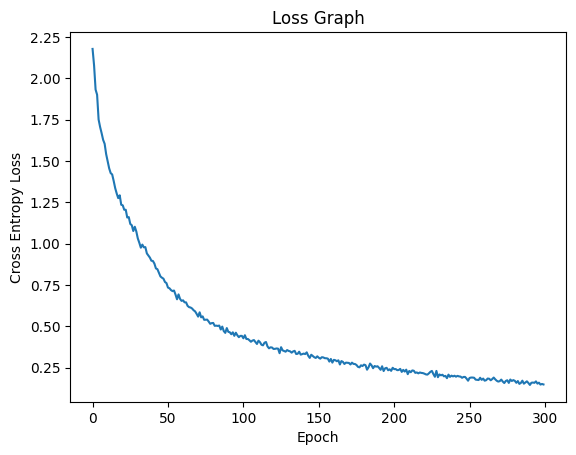

In [26]:
plt.plot(range(epochs),losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.show();

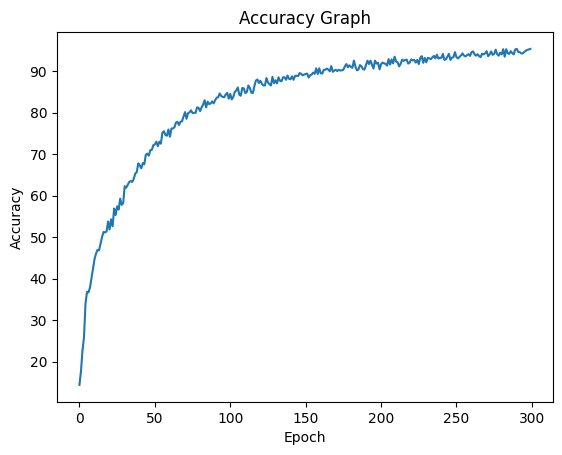

In [27]:
plt.plot(range(epochs),accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.show();

In [28]:
model.eval()

with torch.no_grad():
    y_val = model(cat_test,cont_test)
    print("Loss on test set:", criterion(y_val,y_test))
    print(f"Accuracy on test set: {round((torch.max(y_val,1)[1] == y_test).sum().item() / len(y_test) * 100,2):.2f}%")

Loss on test set: tensor(0.0328, device='cuda:0')
Accuracy on test set: 100.00%


## Saving and loading the trained model

In [29]:
torch.save(model,'obesity_risk_classifier.pt')

In [30]:
loaded_model = torch.load('obesity_risk_classifier.pt')
loaded_model

/tmp/ipykernel_36/2490769120.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('obesity_risk_classifier.pt')


ANN(
  (embeddings): ModuleList(
    (0-2): 3 x Embedding(2, 1)
    (3): Embedding(4, 2)
    (4-5): 2 x Embedding(2, 1)
    (6): Embedding(4, 2)
    (7): Embedding(5, 3)
  )
  (emb_dropout): Dropout(p=0.4, inplace=False)
  (cont_batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=150, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=150, out_features=7, bias=True)
  )
)

## Model Inference

In [31]:
def test_data(model):
    gender = input("What is your gender? (Male/Female)").capitalize()
    family_overweight_history = input("Does your family have an overweight history? (yes/no)").lower()
    favc = input("Do you have fresh air ventilation control? (yes/no)").lower()
    caec = input("How is your consumption of food between meals? (Sometimes/Frequently/Always/No)").capitalize()
    smoke = input("Do you smoke? (yes/no)").lower()
    scc = input("Do you have SCC(Squamous Cell Carcinoma)? (yes/no)").lower()
    calc = input("How is your calcium intake? (Sometimes/No/Frequently/Always)").capitalize()
    mtrans = input("What is your mode of transport? (Public_Transportation/Automobile/Walking/Motorbike/Bike)").capitalize()
    age = float(input("What is your age?"))
    height = float(input("What is your height?"))
    weight = float(input("What is your weight?"))
    fcvc = float(input("What is your frequency of consuming vegetables?"))
    ncp = float(input("How good is your nursing care plan?"))
    ch2o = float(input("How many liters of water do you consume per day?"))
    faf = float(input("How frequently do you do physical activity?"))
    tue = float(input("What is your total body mass?"))
    
    gender_map = {'Female': 0, 'Male': 1}
    foh_map = {'no': 0, 'yes': 1}
    favc_map = {'no': 0, 'yes': 1}
    caec_map = {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'No': 3}
    smoke_map = {'no': 0, 'yes': 1}
    scc_map = {'no': 0, 'yes': 1}
    calc_map = {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'No': 3}
    mtrans_map = {'Automobile': 0,
     'Bike': 1,
     'Motorbike': 2,
     'Public_Transportation': 3,
     'Walking': 4}
    
    gender = gender_map[gender]
    family_overweight_history = foh_map[family_overweight_history]
    favc = favc_map[favc]
    caec = caec_map[caec]
    smoke = smoke_map[smoke]
    scc = scc_map[scc]
    calc = calc_map[calc]
    mtrans = mtrans_map[mtrans]
    
    x_cat = torch.tensor([gender,family_overweight_history,favc,caec,smoke,scc,calc,mtrans],dtype=torch.int64).reshape(1,-1).cuda()
    x_cont = torch.tensor([age,height,weight,fcvc,ncp,ch2o,faf,tue],dtype=torch.float32).reshape(1,-1).cuda()
    
    model.eval()
    
    with torch.no_grad():
        pred = model(x_cat,x_cont).argmax().item()
        
    print(f"Your predicted obesity risk is {encoded_labels[pred]}.")

In [32]:
test_data(model)

What is your gender? (Male/Female) male
Does your family have an overweight history? (yes/no) yes
Do you have fresh air ventilation control? (yes/no) no
How is your consumption of food between meals? (Sometimes/Frequently/Always/No) sometimes
Do you smoke? (yes/no) yes
Do you have SCC(Squamous Cell Carcinoma)? (yes/no) no
How is your calcium intake? (Sometimes/No/Frequently/Always) frequently
What is your mode of transport? (Public_Transportation/Automobile/Walking/Motorbike/Bike) automobile
What is your age? 38
What is your height? 183
What is your weight? 74
What is your frequency of consuming vegetables? 2.1835
How good is your nursing care plan? 1.3956
How many liters of water do you consume per day? 2.1309
How frequently do you do physical activity? 1.6384
What is your total body mass? 1.3748


Your predicted obesity risk is Insufficient_Weight.
